In [1]:
import os 
from glob import glob
from tqdm import tqdm 
import gc

from PIL import Image
from scipy import ndimage as nd
from scipy.ndimage import distance_transform_edt
import tifffile

import numpy as np
import matplotlib.pyplot as plt

import pypore3d 
from pypore3d import *
from pypore3d.p3dFiltPy import *
# from pypore3d.p3dBlobPy import *
# from pypore3d.p3dSkelPy import *
# from pypore3d.p3dSITKPy import *

from poreUtils import *

In [2]:
root_dir = 'D:\sagar\Data'
scan = 'MD_1264_A6_1_Z3.3mm_corr_phrt'
scan_path = os.path.join(root_dir, scan, 'slices')
roi_path = os.path.join(root_dir, scan, 'result')

In [4]:
# volume dimension 
Z, Y, X = 1700, 3681, 3681

vis_xl = 950
vis_xh = 3050

vis_yl = 900
vis_yh = 3600

# Reading the original volume with clipping and converted to 8bit 
tiffs = os.listdir(scan_path)

vol = np.empty(shape=(Z, Y, X), dtype=np.uint8)
for i, fname in enumerate(tqdm(tiffs)):
    im = Image.open(os.path.join(scan_path, fname))
    imarray = np.array(im)
    imarray = np.clip(imarray, 0.0005, 0.003)
    imarray = norm8bit(imarray)
    vol[i, :, :] = imarray

 74%|█████████████████████████████████████████████████████████▊                    | 1260/1700 [08:04<02:57,  2.47it/s]D:\sagar\poreAnalysis\poreUtils.py:127: RuntimeWarning: invalid value encountered in subtract
  v = ((v - minVal)/maxVal) * 255
100%|██████████████████████████████████████████████████████████████████████████████| 1700/1700 [11:09<00:00,  2.54it/s]


In [5]:
# Available ROIs
rois = glob(os.path.join(roi_path, '*.raw'))
roidict = {}

lst = []
for r in rois:
    roidict[r.split('\\')[-1:][0].split('x')[0]] = [] 
    
for rd in roidict:
    dlst = []
    for r in rois:
        if rd == r.split('\\')[-1:][0].split('x')[0]:
            #print('yes')
            dlst.append(r)
    roidict[rd] = dlst    

In [6]:

sel_roi_lr = 200
sel_roi_hr = 500


roi_key = str(sel_roi_lr)+'-'+str(sel_roi_hr) 

# Binarization value for distance transform  
threshold = 40 

# 
dist_thrs = 2

# roi dimension 
x, y, z = 300, 300, 300

# 3d mask for distance transform and size same to the total volume but depth is equal to roi depth 
roi_mask = np.empty(shape=(z, X,Y))
roi_mask[:, :, :] = np.nan

for r in roidict[roi_key]:

    volc = py_p3dReadRaw8(r, x, y, z)
    # convert it to numpy array for manual thresholding and a bit processing which are easy in numpy array
    roi = swigObjt2uint8Array(volc, x, y, z) 
    th_roi = roi > threshold
    th_roi = nd.binary_closing(th_roi, np.ones((3,3,3)))
    dis3d = distance_transform_edt(th_roi)
    #msk = dis3d > dist_thrs
    #dist_img = msk*roi
    dis3d[dis3d < dist_thrs] = np.nan

    ly = int(r.split('\\')[-1:][0].split('_8bit.raw')[0].split('x')[1].split('-')[0])
    hy = int(r.split('\\')[-1:][0].split('_8bit.raw')[0].split('x')[1].split('-')[1])
    
    lx = int(r.split('\\')[-1:][0].split('_8bit.raw')[0].split('x')[2].split('-')[0])
    hx = int(r.split('\\')[-1:][0].split('_8bit.raw')[0].split('x')[2].split('-')[1])
    
    roi_mask[:, ly:hy, lx:hx] = dis3d[:, :, :]

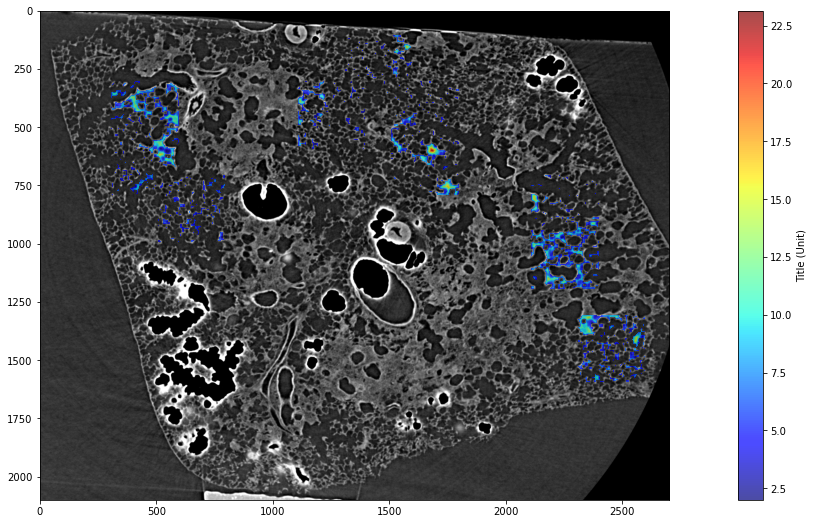

In [8]:
sliceNo = 250 # with respect to whole volume
slice_at_roi = sliceNo - sel_roi_lr

vis_xl = 950
vis_xh = 3050

vis_yl = 900
vis_yh = 3600

plt.figure(figsize=(25,9))

plt.imshow(vol[sliceNo, vis_xl:vis_xh,  vis_yl:vis_yh], cmap='gray')
#cbar = plt.colorbar(orientation='horizontal')
#cbar.set_label('Title (Unit)')

plt.imshow(roi_mask[slice_at_roi, vis_xl:vis_xh,  vis_yl:vis_yh], cmap=plt.cm.jet, alpha=0.7)
cbar = plt.colorbar()
cbar.set_label('Title (Unit)')
#plt.savefig('test.png', dpi=100)
plt.show() 


# plt.figure(figsize=(25,9))
# plt.imshow(vol[sliceNo, vis_xl:vis_xh,  vis_yl:vis_yh], cmap='gray')#, alpha=0.5)
# # cbar = plt.colorbar(orientation='horizontal')
# # cbar.set_label('Title (Unit)')
# plt.show()

# plt.figure(figsize=(25,9))
# plt.imshow(roi_mask[slice_at_roi, vis_xl:vis_xh,  vis_yl:vis_yh], cmap='jet')#
# #cbar = plt.colorbar()
# #cbar.set_label('Title (Unit)')
# plt.show()

In [9]:
import ipywidgets as widgets 
from ipywidgets import VBox, HBox

In [8]:
# Slider interface for selecting the sliceNo to visualize 
slider = widgets.widgets.BoundedIntText(
    value=150,
    min=0,
    max=299,
    step=1,
    description='Slice',
    disabled=False
)

# Slider interface for selecting the sliceNo to visualize 
alphaslider = widgets.FloatSlider(min=0.0, max=1.0, value=0.7, step=0.1, description='Alpha')

visXrange = widgets.IntRangeSlider(
    value=[vis_xl, vis_xh],
    min=vis_xl,
    max=vis_xh,
    step=1,
    description='Range Y',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

visYrange = widgets.IntRangeSlider(
    value=[vis_yl, vis_yh],
    min=vis_yl,
    max=vis_yh,
    step=1,
    description='Range X',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)

ui = VBox([HBox([slider, alphaslider]), HBox([visXrange, visYrange])])

print('Binarization threshold: ', threshold, '\n Distance Threshold used: ', dist_thrs)

def interactiveVis(select_slice, visX, visY, alpha, volume=vol, r_mask=roi_mask, init_slice=sel_roi_lr):

    sliceNo = init_slice + select_slice
    print('Slice No :', sliceNo)
    vis_xl = visX[0]
    vis_xh = visX[1]

    vis_yl = visY[0]
    vis_yh = visY[1]

    plt.figure(figsize=((vis_yh-vis_yl)/100,(vis_xh-vis_xl)/100))

    plt.imshow(volume[sliceNo, vis_xl:vis_xh,  vis_yl:vis_yh], cmap='gray')
    #cbar = plt.colorbar(orientation='horizontal')
    #cbar.set_label('Title (Unit)')

    plt.imshow(r_mask[select_slice, vis_xl:vis_xh,  vis_yl:vis_yh], cmap=plt.cm.jet, alpha=alpha)
    cbar = plt.colorbar()
    cbar.set_label('Title (Unit)')
    plt.show()


out = widgets.interactive_output(interactiveVis, {'select_slice':slider, 'visX':visXrange, 'visY':visYrange, 'alpha':alphaslider})

display(ui, out)

Binarization threshold:  40 
 Distance Threshold used:  2


Output()

In [10]:
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

# Interactive Visualization 

slice_range = widgets.Dropdown(
            options=[k for k in roidict],
            value=list(roidict.keys())[0],
            description='slice range',
            )

select_thrshold = widgets.BoundedIntText(
    value=55,
    min=0,
    max=255,
    step=1,
    description='Threshold',
    disabled=False
)

select_dist_thres = widgets.BoundedIntText(
    value=2,
    min=1,
    max=10,
    step=1,
    description='Distance Threshold',
    disabled=False
)


def interactiveValue(roiRange, threshold, dist_thrs):
    
    roi_key = str(roiRange.split('-')[0])+'-'+str(roiRange.split('-')[1]) 

    # roi dimension 
    x, y, z = 300, 300, 300
        
    # 3d mask for distance transform and size same to the total volume but depth is equal to roi depth 
    roi_mask = np.empty(shape=(z,Y,X), dtype=np.float32)
    roi_mask[:, :, :] = np.nan
    
    print('Loading slices ', roi_key, '......')
    
    for r in tqdm(roidict[roi_key]):

        volc = py_p3dReadRaw8(r, x, y, z)
        # convert it to numpy array for manual thresholding and a bit processing which are easy in numpy array
        roi = swigObjt2uint8Array(volc, x, y, z) 
        th_roi = roi > threshold
        #th_vol = nd.binary_closing(th_vol, np.ones((3,3,3)))
        dis3d = distance_transform_edt(th_roi)
        #msk = dis3d > dist_thrs
        #dist_img = msk*roi
        #dist_img = msk*dis3d
        dis3d[dis3d < dist_thrs] = np.nan

        ly = int(r.split('\\')[-1:][0].split('_8bit.raw')[0].split('x')[1].split('-')[0])
        hy = int(r.split('\\')[-1:][0].split('_8bit.raw')[0].split('x')[1].split('-')[1])

        lx = int(r.split('\\')[-1:][0].split('_8bit.raw')[0].split('x')[2].split('-')[0])
        hx = int(r.split('\\')[-1:][0].split('_8bit.raw')[0].split('x')[2].split('-')[1])

        #roi_mask[:, ly:hy, lx:hx] = dist_img[:, :, :]
        roi_mask[:, ly:hy, lx:hx] = dis3d[:, :, :]
    

    # Slider interface for selecting the sliceNo to visualize 
    slider = widgets.IntSlider(min=0, max=299, value=150, description='slice')

    # Slider interface for selecting the sliceNo to visualize 
    alphaslider = widgets.FloatSlider(min=0.0, max=1.0, value=0.7, step=0.1, description='Alpha')

    visXrange = widgets.IntRangeSlider(
        value=[vis_xl, vis_xh],
        min=vis_xl,
        max=vis_xh,
        step=1,
        description='Range Y',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d',
    )

    visYrange = widgets.IntRangeSlider(
        value=[vis_yl, vis_yh],
        min=vis_yl,
        max=vis_yh,
        step=1,
        description='Range X',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d',
    )
    
    savebtn = widgets.ToggleButton(
        value=False,
        description='Save',
        disabled=False,
        button_style='', # 'success', 'info', 'warning', 'danger' or ''
        tooltip='Description',
        #icon='check' # (FontAwesome names without the `fa-` prefix)
    )

    ui = VBox([HBox([slider, alphaslider]), HBox([visXrange, visYrange, savebtn])])

    def interactiveVis(select_slice, visX, visY, alpha, save, volume=vol, r_mask=roi_mask, init_slice=int(roiRange.split('-')[0])):

        sliceNo = init_slice + select_slice
        print('Slice No :', sliceNo)
        vis_xl = visX[0]
        vis_xh = visX[1]

        vis_yl = visY[0]
        vis_yh = visY[1]

        plt.figure(figsize=((vis_yh-vis_yl)/100,(vis_xh-vis_xl)/100))

        plt.imshow(volume[sliceNo, vis_xl:vis_xh,  vis_yl:vis_yh], cmap='gray')
        #cbar = plt.colorbar(orientation='horizontal')
        #cbar.set_label('Title (Unit)')

        plt.imshow(r_mask[select_slice, vis_xl:vis_xh,  vis_yl:vis_yh], cmap=plt.cm.jet, alpha=alpha)
        cbar = plt.colorbar()
        cbar.set_label('Distance (in pixel)')
        if save:
            plt.savefig((str(sliceNo) + 'T' + str(threshold) + 'dT' + str(dist_thrs) + '.png'), dpi=100)
        plt.show()


    out = widgets.interactive_output(interactiveVis, {'select_slice':slider, 'visX':visXrange, 'visY':visYrange, 'alpha':alphaslider, 'save':savebtn})

    display(ui, out)
    
widgets.interact(interactiveValue, roiRange=slice_range, threshold=select_thrshold, dist_thrs=select_dist_thres)

interactive(children=(Dropdown(description='slice range', options=('0-300', '1000-1300', '1200-1500', '1400-17…

<function __main__.interactiveValue(roiRange, threshold, dist_thrs)>